In [118]:
import PyPlot
using NearestNeighbors
using SplineUtils

In [2]:
R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]

R (generic function with 1 method)

# Build Road Networks from Intersections

In [ ]:
function DubbinsCurveBetweenPts()
end

In [3]:
type Lane
    id
    spline
    length
    Pts
    boundaryLeft
    boundaryRight
    predecessors
    successors
    neighborsLeft
    neighborsRight
    function Lane(id, spline)
        lane = new()
        lane.id = id
        lane.spline = spline
        lane.length = lane.spline.s[end]
        lane.Pts = []
        lane.boundaryLeft = nothing
        lane.boundaryRight = nothing
        lane.predecessors = nothing
        lane.successors = nothing
        lane.neighborsLeft = nothing
        lane.neighborsRight = nothing
        return lane
    end
end

In [4]:
type Road
    id
    spline
    Pts
    lanes
    successors # other roads
    predecessors # other lanes
    speed
    
    function Road(id, spline, speed)
        road = new()
        road.id = id
        road.spline = spline
        road.successors = none
        road.predecessors = none
        road.speed = speed
        return road
    end
end

In [5]:
type curvePt
    id
    x
    y
    θ # heading
    s # arc length
    k # curvature
    function curvePt()
        pt = new()
        pt.id = nothing
        pt.x = nothing
        pt.y = nothing
        pt.θ = nothing
        pt.s = nothing
        pt.k = nothing
        return pt
    end
end

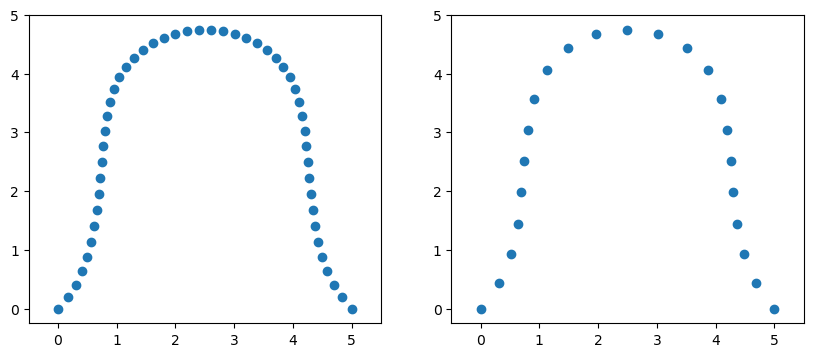

In [6]:
controlPts = [0.0 1.0 0.0 5.0 4.0 5.0; 0.0 1.0 5.0 5.0 1.0 0.0]
degree = 3
numPts = 50
spline = Bspline(controlPts, degree, numPts; resample=false, Δs=0.1);
PyPlot.figure(figsize=[10,4])
PyPlot.subplot(1,2,1)
PyPlot.scatter(spline.x,spline.y)
PyPlot.axis("equal");
ResampleByArcLength!(spline; Δs=0.5)
PyPlot.subplot(1,2,2)
PyPlot.scatter(spline.x,spline.y)
PyPlot.axis("equal");

In [8]:
type id_dispenser
    available_ids
    function id_dispenser(num_ids)
        retval = new()
        retval.available_ids = Set(i for i in 1:num_ids)
        return retval
    end
end

In [9]:
function getId(dispenser::id_dispenser)
    return pop!(dispenser.available_ids)
end

getId (generic function with 1 method)

In [10]:
dispenser = id_dispenser(100)

id_dispenser(Set([68, 2, 89, 11, 39, 46, 85, 25, 55, 42  …  72, 28, 5, 23, 63, 27, 56, 97, 41, 15]))

In [11]:
intersections = Dict()
block_array = Dict()
for i in 0:5
    for j in 0:5
        id = getId(dispenser)
        block_array[(i,j)] = id
        θ₁ = rand() / 4
        θ₂ = θ₁ + π/2
        x = i*10.0 + rand()
        y = j*10.0 + rand()
        intersections[id] = Intersection(id, x, y, θ₁, θ₂)
    end
end
for i in 1:4
    for j in 1:4
        id = block_array[(i,j)]
        intersections[id].connection_N = block_array[(i,j+1)]
        intersections[id].connection_E = block_array[(i+1,j)]
        intersections[id].connection_S = block_array[(i,j-1)]
        intersections[id].connection_W = block_array[(i-1,j)]
    end
end

In [12]:
function generateSpline(pt₁, pt₂, θ₁, θ₂; numPts=100, degree=3, resample=false, Δs=0.5)
    """
    generates a spline that leaves pt1 at heading θ₁, and arrives
    at pt2 with heading θ₂
    """
    d = norm(pt₁-pt₂)
    V₁ = (d/4) * R(θ₁) * [
        0.0 1.0;
        0.0 0.0
    ] .+ pt₁
    V₂ = (d/4) * R(θ₂+π) * [
        1.0 0.0;
        0.0 0.0
    ] .+ pt₂
    Pts = hcat(V₁,(V₁[:,end]+V₂[:,1])/2,V₂)
    spline = Bspline(Pts, degree, numPts; resample=resample, Δs=Δs)
    return spline
end

generateSpline (generic function with 1 method)

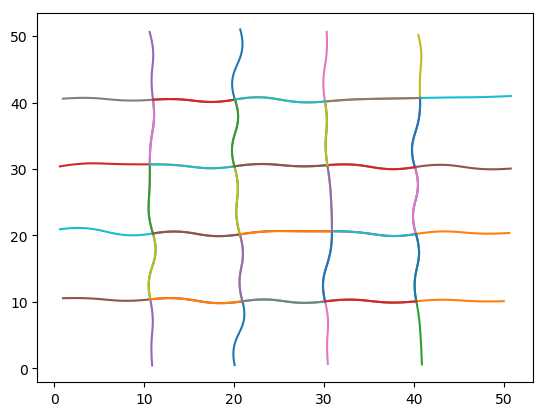

In [13]:
for (id,I) in intersections
    if I.connection_N > -1
        I₂ = intersections[I.connection_N]
        spline = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₂, I₂.θ₂)
        PyPlot.plot(spline.x,spline.y) # plot generated spline roadway
    end
    if I.connection_E > -1
        I₂ = intersections[I.connection_E]
        spline = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₁, I₂.θ₁)
        PyPlot.plot(spline.x,spline.y) # plot generated spline roadway
    end
    if I.connection_S > -1
        I₂ = intersections[I.connection_S]
        spline = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₂+π, I₂.θ₂+π)
        PyPlot.plot(spline.x,spline.y) # plot generated spline roadway
    end
    if I.connection_W > -1
        I₂ = intersections[I.connection_W]
        spline = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₁+π, I₂.θ₁+π)
        PyPlot.plot(spline.x,spline.y) # plot generated spline roadway
    end
end

# Construct Intersection from list of incoming lanes and transitions

In [7]:
type Intersection
    id
    x
    y
    θ₁
    θ₂
    LanesIn
    LanesOut
    
    connections_out # Dict(:North, :East, :South, :West) => road_id
    connections_in # Dict(:North, :East, :South, :West) => road_id
    
    entrances # Dict(:North, :East, :South, :West) => Dict(-1, 0, 1, ..., offset) => ID(s) of associated lanes
    exits # Dict(:North, :East, :South, :West) => Dict(-1, 0, 1, ..., offset) => ID(s) of associated lanes
    refpoints # Dict(:North, :East, :South, :West) => Dict(:in,:out) => [x;y]
    lanes # Dict(:North, :East, :South, :West) => (x, y)
    
    function Intersection(id,x,y,θ₁,θ₂,LanesIn)
        retval = new()
        retval.id = id
        retval.x = x
        retval.y = y
        retval.θ₁ = θ₁
        retval.θ₂ = θ₂
        retval.connections_out = Dict( k => -1 for k in [:North, :East, :South, :West])
        retval.connections_in = Dict( k => -1 for k in [:North, :East, :South, :West])
        retval.LanesIn = LanesIn
        retval.LanesOut = nothing
        
        retval.entrances = Dict(
            :North => Dict(),
            :South => Dict(),
            :East => Dict(),
            :West => Dict()
        )
        retval.exits = Dict(
            :North => Dict(),
            :South => Dict(),
            :East => Dict(),
            :West => Dict()
        )
        retval.refpoints = Dict(
            :North => Dict(),
            :South => Dict(),
            :East => Dict(),
            :West => Dict()
        )
        retval.lanes = Dict(
            :North => [],
            :South => [],
            :East => [],
            :West => []
        )
        return retval
    end
end

In [614]:
function populateIntersection!(intersection,LanesIn;w=1,b=1,Δs=0.5)
    """
    arguments:
    
    intersection = Intersection object
    LanesIn = Dict(
        :North => [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
        :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
        :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
        :West => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
    )
    """
    x₀ = intersection.x
    y₀ = intersection.y
    θ₁ = intersection.θ₁
    θ₂ = intersection.θ₂
    
    Directions = [:North, :East, :South, :West]
    θ = Dict(:East => θ₁, :North => θ₂, :West => θ₁+π, :South => θ₂+π)
    Left = Dict(:North => :West, :East => :North, :South => :East, :West => :South)
    Right = Dict(:North => :East, :East => :South, :South => :West, :West => :North)
    Opposite = Dict(:North => :South, :East => :West, :South => :North, :West => :East)
    LanesOut = Dict( k => [Set([:Straight]) for i in 1:max(
                    sum([Int(:Straight in lane) for lane in LanesIn[k]]),
                    sum([Int(:Left in lane) for lane in LanesIn[Right[k]]]),
                    sum([Int(:Right in lane) for lane in LanesIn[Left[k]]]),)] for k in Directions)
    D = Dict( k => max(length(LanesIn[k]) + length(LanesOut[Opposite[k]]),
            length(LanesIn[Opposite[k]]) + length(LanesOut[k])) for k in Directions)
    # incoming lanes - lateral position begins from the right side                          
    PositionsIn = Dict( k => [i for i in 1:length(LanesIn[k])] for k in Directions)
    # reference positions - for specifying incoming roadway geometry
    PositionRefs = Dict( 
        k => sum([Int(:Straight in lane || :Right in lane) for lane in LanesIn[k]]) for k in Directions)
    # outgoing lanes - lateral position counts down from left side (leftover positions are empty--no lanes in them)
    PositionsOut = Dict(
        k => [D[k] + 1 - i for i in 1:length(LanesOut[k])] for k in Directions 
    )
    d = Dict( k => w*D[k]/2 + b for k in Directions)
    d_vecs = Dict( k => d[Right[k]] * R(θ[k]) * [1;0] for k in Directions)
    ctrs = Dict( k => d_vecs[k] + [x₀;y₀] for k in Directions)
    corners = Dict((k, Left[k]) => d_vecs[k] + d_vecs[Left[k]] + [x₀;y₀] for k in Directions)
    # entry points
    EntryPoints = Dict( 
        k => [(corners[Opposite[k], Right[k]] .+ normalize(
                    d_vecs[Left[k]])*(w*(p-.5) + b)) for p in PositionsIn[k]] for k in Directions
        )
    # reference points in
    RefPts_In = Dict(
        k => EntryPoints[k][PositionRefs[k]] .+ normalize(d_vecs[Left[k]])*w*0.5 for k in Directions
        )
    
    # exit points
    ExitPoints = Dict(
        k => [(corners[(k, Left[k])] .+ normalize(
                    d_vecs[Right[k]])*(w*(p.-.5) + b)) for p in PositionsOut[k]] for k in Directions
        )
    # reference points out
    RefPts_Out = Dict(
        k => ExitPoints[k][end] .+ normalize(d_vecs[Left[k]])*w*0.5 for k in Directions
    )
    # intersection ref points
    for (k, pt) in RefPts_In
        intersection.refpoints[k][:in] = pt
    end
    for (k, pt) in RefPts_Out
        intersection.refpoints[k][:out] = pt
    end

    for (j,direction) in enumerate(Directions)
        for (i,lane) in enumerate(reverse(LanesIn[direction]))
            if :Straight in lane
                pt₁ = EntryPoints[direction][i]
                pt₂ = ExitPoints[direction][i]
                x = collect(linspace(pt₁[1],pt₂[1]))
                y = collect(linspace(pt₁[2],pt₂[2]))
                push!(intersection.lanes[direction], (x,y))
            end
            if :Right in lane
#                 x = []
#                 y = []
                pt₁ = EntryPoints[direction][i]
                pt₂ = ExitPoints[Right[direction]][i]
                x,y = Dubbins(pt₁,pt₂,θ[direction],θ[Right[direction]])
#                 ctr = corners[(Opposite[direction], Right[direction])]
#                 Δ₁ = pt₁ - ctr
#                 Δ₂ = pt₂ - ctr
#                 if norm(Δ₂) - norm(Δ₁) > 0.01
#                     append!(x,pt₁[1])
#                     append!(y,pt₁[2])
#                     pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
#                     ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
#                     Δ₁ = pt₁ - ctr
#                     r = norm(Δ₁)
#                     ϕ₁ = atan2(Δ₁[2],Δ₁[1])
#                     ϕ₂ = atan2(Δ₂[2],Δ₂[1])
#                     ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
#                     x = vcat(x, r*cos.(ϕ) + ctr[1])
#                     y = vcat(y, r*sin.(ϕ) + ctr[2])
#                 elseif norm(Δ₁) - norm(Δ₂) > 0.01
#                     append!(x,pt₂[1])
#                     append!(y,pt₂[2])
#                     pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
#                     ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
#                     Δ₂ = pt₂ - ctr
#                     r = norm(Δ₁)
#                     ϕ₁ = atan2(Δ₁[2],Δ₁[1])
#                     ϕ₂ = atan2(Δ₂[2],Δ₂[1])
#                     ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
#                     x = vcat(r*cos.(ϕ) + ctr[1], x)
#                     y = vcat(r*sin.(ϕ) + ctr[2], y)
#                 else
#                     r = norm(Δ₁)
#                     ϕ₁ = atan2(Δ₁[2],Δ₁[1])
#                     ϕ₂ = atan2(Δ₂[2],Δ₂[1])
#                     ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
#                     x = r*cos.(ϕ) + ctr[1]
#                     y = r*sin.(ϕ) + ctr[2]
#                 end
                push!(intersection.lanes[direction], (x,y))
            end
        end
        for (i,lane) in enumerate(LanesIn[direction])
            if :Left in lane
                pt₁ = reverse(EntryPoints[direction])[i]
                pt₂ = reverse(ExitPoints[Left[direction]])[i]
                x,y = Dubbins(pt₁,pt₂,θ[direction],θ[Left[direction]])
#                 x = []
#                 y = []
#                 pt₁ = reverse(EntryPoints[direction])[i]
#                 pt₂ = reverse(ExitPoints[Left[direction]])[i]
#                 ctr = corners[(Left[direction], Opposite[direction])]
#                 Δ₁ = pt₁ - ctr
#                 Δ₂ = pt₂ - ctr
#                 if norm(Δ₂) - norm(Δ₁) > 0.01
#                     append!(x,pt₁[1])
#                     append!(y,pt₁[2])
#                     pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
#                     ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
#                     Δ₁ = pt₁ - ctr
#                     Δ₂ = pt₂ - ctr
#                     r = norm(Δ₁)
#                     ϕ₁ = atan2(Δ₁[2],Δ₁[1])
#                     ϕ₂ = atan2(Δ₂[2],Δ₂[1])
#                     ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
#                     x = vcat(x, r*cos.(ϕ) + ctr[1])
#                     y = vcat(y, r*sin.(ϕ) + ctr[2])
#                 elseif norm(Δ₁) - norm(Δ₂) > 0.01
#                     append!(x,pt₂[1])
#                     append!(y,pt₂[2])
#                     pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
#                     ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
#                     Δ₁ = pt₁ - ctr
#                     Δ₂ = pt₂ - ctr
#                     r = norm(Δ₂)
#                     ϕ₁ = atan2(Δ₁[2],Δ₁[1])
#                     ϕ₂ = atan2(Δ₂[2],Δ₂[1])
#                     ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
#                     x = vcat(r*cos.(ϕ) + ctr[1], x)
#                     y = vcat(r*sin.(ϕ) + ctr[2], y)
#                 else
#                     r = norm(Δ₁)
#                     ϕ₁ = atan2(Δ₁[2],Δ₁[1])
#                     ϕ₂ = atan2(Δ₂[2],Δ₂[1])
#                     ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
#                     x = r*cos.(ϕ) + ctr[1]
#                     y = r*sin.(ϕ) + ctr[2]
#                 end
                push!(intersection.lanes[direction], (x,y))
            end
        end
    end
end

populateIntersection! (generic function with 1 method)

In [630]:
id = 0
x = 0
y = 0
θ₁ = -π/6
θ₂ = θ₁+π/3
I1 = Intersection(id,x,y,θ₁,θ₂);

In [631]:
id = 1
θ₁ = π/6
θ₂ = θ₁+π/2
I2 = Intersection(id,33,2,θ₁,θ₂);

In [632]:
LanesIn = Dict(
    :North => [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :East => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :South => [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])],
    :West => [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
)
populateIntersection!(I1,LanesIn; b=3)
populateIntersection!(I2,LanesIn; b=3)

In [633]:
splineA = generateSpline(I1.refpoints[:East][:out], I2.refpoints[:East][:in], I1.θ₁, I2.θ₁; degree=3);
splineB = generateSpline(I2.refpoints[:West][:out], I1.refpoints[:West][:in], I2.θ₁+π, I1.θ₁+π; degree=3);
splineC = generateSpline(I2.refpoints[:North][:out], I1.refpoints[:South][:in], I2.θ₂, I1.θ₂+π; degree=3);
splineD = generateSpline(I1.refpoints[:North][:out], I2.refpoints[:South][:in], I1.θ₂, I2.θ₂+π; degree=3);

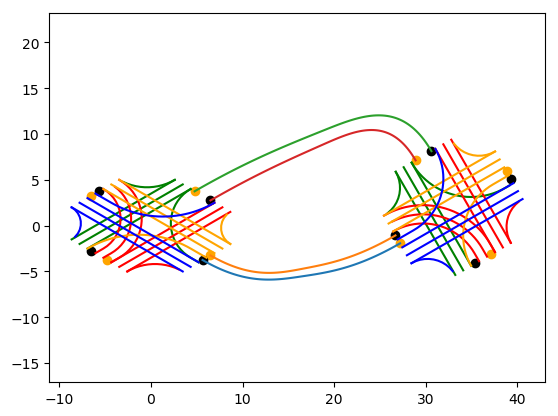

In [634]:
colors = Dict(
    :North => "red",
    :East => "blue",
    :South => "green",
    :West => "orange",
)
for (direction, lanes) in I1.lanes
    for lane in lanes
        PyPlot.plot(lane[1],lane[2],c=colors[direction])
    end
end
for (direction, refs) in I1.refpoints
    PyPlot.scatter(refs[:in][1],refs[:in][2],c="orange")
    PyPlot.scatter(refs[:out][1],refs[:out][2],c="black")
end
for (direction, lanes) in I2.lanes
    for lane in lanes
        PyPlot.plot(lane[1],lane[2],c=colors[direction])
    end
end
for (direction, refs) in I2.refpoints
    PyPlot.scatter(refs[:in][1],refs[:in][2],c="orange")
    PyPlot.scatter(refs[:out][1],refs[:out][2],c="black")
end
PyPlot.plot(splineA.x,splineA.y)
PyPlot.plot(splineB.x,splineB.y)
PyPlot.plot(splineC.x,splineC.y)
PyPlot.plot(splineD.x,splineD.y)
PyPlot.axis("equal");

In [635]:
splineA = generateSpline(I1.refpoints[:East][:out], I2.refpoints[:East][:in], I1.θ₁, I2.θ₁; degree=3);
refs_in = 
ResampleByArcLength!(splineA; Δs=1.0);

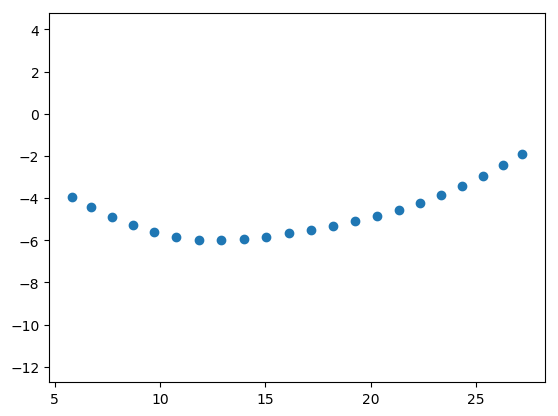

(4.736742383333729, 28.263257616666266, -6.224994685650034, -1.720129206067018)

In [21]:
PyPlot.scatter(splineA.x,splineA.y)

PyPlot.axis("equal")

# Generate Connecting Roadway Geometry (between intersections)

# Dubbins stuff

In [601]:
function Dubbins(pt₁,pt₂,θ₁,θ₂; Δs = 0.5)
    """
    returns points along Dubbins curve from Pt1 to Pt2, sampled at intervals of Δŝ ≋ Δs
    """
    Δθ = θ₂ - θ₁
    vecA = [cos(θ₁);sin(θ₁)]*(pt₂-pt₁)'*[cos(θ₁);sin(θ₁)]
    vecB = (pt₂-pt₁) - vecA
    vecD = [cos(θ₂);sin(θ₂)]*norm(vecB)/abs(sin(Δθ))
    vecC = (pt₂-pt₁) - vecD

    p₁ = pt₁
    p₄ = pt₂
    if norm(vecC) < norm(vecD)
        p₂ = pt₁
        p₃ = pt₂ - vecD*(1-norm(vecC)/norm(vecD))
    elseif norm(vecD) < norm(vecC)
        p₂ = pt₁ + vecC * (1-norm(vecD)/norm(vecC))
        p₃ = pt₂
    else
        p₂ = pt₁
        p₃ = pt₂
    end

    A = (p₃-p₂)'*[cos(θ₁);sin(θ₁)]
    C = A / sin(θ₂-θ₁)
    X = R(θ₁)*[0;C] + p₂  # <==== Center point
    Δ₁ = p₂ - X
    Δ₂ = p₃ - X
    r = norm(Δ₁)
    ϕ₁ = atan2(Δ₁[2],Δ₁[1])
    ϕ₂ = atan2(Δ₂[2],Δ₂[1])
    Δϕ = mod(ϕ₂,2*π)-mod(ϕ₁,2*π)
    if abs(Δϕ) > π
        Δϕ -= sign(Δϕ)*2*π
    end
    vec1 = X + norm(Δ₁)*[cos(ϕ₁);sin(ϕ₁)]
    vec2 = X + norm(Δ₂)*[cos(ϕ₂);sin(ϕ₂)]

    L = norm(p₂-p₁) + abs(r*Δϕ) + norm(p₄-p₃)
    Δŝ = L / ceil(L/Δs)
    # straight line p₁ -> p₂
    pts = p₁
    L₁₂ = norm(p₂-p₁)
    ds = 0
    n = Int(div(L₁₂, Δŝ))
    if n > 0
        pts = pts[:,end] .+ ((p₂-p₁)/L₁₂) * collect(linspace(ds, ds+n*Δŝ, n+1))'
        ds = Δŝ - mod(L₁₂, Δŝ)
    end
    # arc p₁ -> p₂
    ϕ₁ += sign(Δϕ)*ds/r
    Δϕ -= sign(Δϕ)*ds/r
    n = Int(div(abs(Δϕ*r), Δŝ))
    if n > 0
        ϕ = collect(linspace(ϕ₁,ϕ₁+n*sign(Δϕ)*Δŝ/r,n+1))
        pts = hcat(pts, X .+ r * hcat(cos.(ϕ), sin.(ϕ))')
        dϕ = mod(ϕ[end] - ϕ₂,2*π)
        ds = -sign(dϕ) * min(abs(dϕ), abs(2π-dϕ)) * r + Δŝ
    end
    # straight line p₃ -> p₄
    L₃₄ = norm(p₄-p₃)
    n = Int(div(L₃₄ - ds, Δŝ))
    if n > 0
        pts = hcat(pts, p₃ .+ ((p₄-p₃)/L₃₄) * collect(linspace(ds, ds+n*Δŝ, n+1))')
        ds = -mod(L₃₄ - ds, Δŝ)
    end
    
    x = pts[1,:]
    y = pts[2,:]
    return x,y
end

Dubbins (generic function with 3 methods)

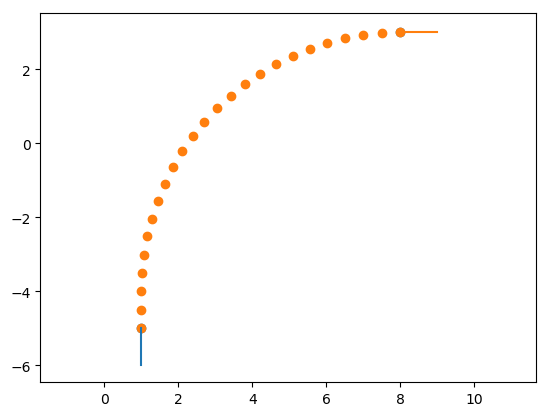

n = Int(div(L₁₂, Δŝ)) = 2
ds = Δŝ - mod(L₁₂, Δŝ) = 0.49944678594553343
n = Int(div(abs(Δϕ * r), Δŝ)) = 21
ds = -(sign(dϕ)) * min(abs(dϕ), abs(2π - dϕ)) * r + Δŝ = 0.49981559531517655
n = Int(div(L₃₄ - ds, Δŝ)) = 0


(0.544070649876431, 9.402663302386836, -6.454021480751392, 3.53445109577922)

In [600]:
# pt₁ = [rand();rand()]
# pt₂ = 10*[rand();rand()]
# θ = atan2((pt₂-pt₁)[1],(pt₂-pt₁)[2])
# θ₁ = θ + (rand() - 0.5) * 3*π/4
# θ₂ = θ + sign(θ - θ₁)*rand() * π/2

pt₁ = [1;-5]
pt₂ = [8;3]
θ₁ = 4π/8
θ₂ = 0

x,y = Dubbins(pt₁,pt₂,θ₁,θ₂)
PyPlot.scatter([pt₁[1], pt₂[1]],[pt₁[2], pt₂[2]])
PyPlot.plot([pt₁[1], (R(θ₁)*[-1;0]+pt₁)[1]],[pt₁[2], (R(θ₁)*[-1;0]+pt₁)[2]])
PyPlot.plot([pt₂[1], (R(θ₂)*[1;0]+pt₂)[1]],[pt₂[2], (R(θ₂)*[1;0]+pt₂)[2]])
PyPlot.scatter(x,y)
PyPlot.axis("equal")

In [138]:
Δs = 0.5

0.5

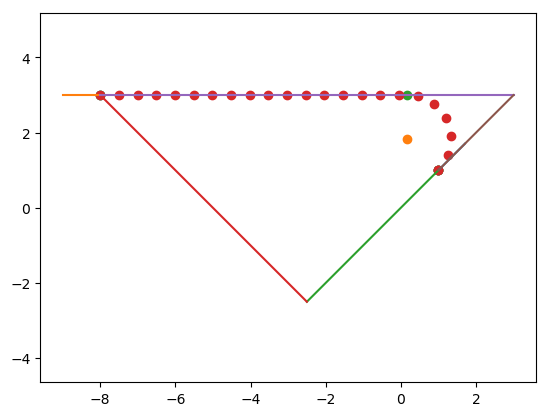

n = Int(div(L₁₂, Δŝ)) = 0
n = Int(div(abs(Δϕ * r), Δŝ)) = 5
ds = -(sign(dϕ)) * min(abs(dϕ), abs(2π - dϕ)) * r + Δŝ = 0.22100819977334613
n = Int(div(L₃₄ - ds, Δŝ)) = 16
ds = -(mod(L₃₄ - ds, Δŝ)) = -0.0


(-9.6, 3.5999999999999983, -2.7774773123281373, 3.327023558890885)

In [591]:
pt₁ = [1;1]
pt₂ = [-8;3]
θ₁ = π/4
θ₂ = π
Δθ = θ₂ - θ₁

vecA = [cos(θ₁);sin(θ₁)]*(pt₂-pt₁)'*[cos(θ₁);sin(θ₁)]
vecB = (pt₂-pt₁) - vecA
vecD = [cos(θ₂);sin(θ₂)]*norm(vecB)/abs(sin(Δθ))
vecC = (pt₂-pt₁) - vecD

p₁ = pt₁
p₄ = pt₂

if norm(vecC) < norm(vecD)
    p₂ = pt₁
    p₃ = pt₂ - vecD*(1-norm(vecC)/norm(vecD))
elseif norm(vecD) < norm(vecC)
    p₂ = pt₁ + vecC * (1-norm(vecD)/norm(vecC))
    p₃ = pt₂
else
    p₂ = pt₁
    p₃ = pt₂
end

A = (p₃-p₂)'*[cos(θ₁);sin(θ₁)]
C = A / sin(θ₂-θ₁)
X = R(θ₁)*[0;C] + p₂# <==== Center point

Δ₁ = p₂ - X
Δ₂ = p₃ - X
r = norm(Δ₁)
ϕ₁ = atan2(Δ₁[2],Δ₁[1])
ϕ₂ = atan2(Δ₂[2],Δ₂[1])
Δϕ = mod(ϕ₂,2*π)-mod(ϕ₁,2*π)
if abs(Δϕ) > π
    Δϕ -= sign(Δϕ)*2*π
end

vec1 = X + norm(Δ₁)*[cos(ϕ₁);sin(ϕ₁)]
vec2 = X + norm(Δ₂)*[cos(ϕ₂);sin(ϕ₂)]

L = norm(p₂-p₁) + abs(r*Δϕ) + norm(p₄-p₃)
Δŝ = L / ceil(L/Δs)
# straight line p₁ -> p₂
pts = p₁
L₁₂ = norm(p₂-p₁)
ds = 0
@show n = Int(div(L₁₂, Δŝ))
if n > 0
    pts = pts[:,end] .+ ((p₂-p₁)/L₁₂) * collect(linspace(ds, ds+n*Δŝ, n+1))'
    @show ds = Δŝ - mod(L₁₂, Δŝ)
end
# arc p₁ -> p₂
ϕ₁ += sign(Δϕ)*ds/r
Δϕ -= sign(Δϕ)*ds/r
@show n = Int(div(abs(Δϕ*r), Δŝ))
if n > 0
    ϕ = collect(linspace(ϕ₁,ϕ₁+n*sign(Δϕ)*Δŝ/r,n+1))
    pts = hcat(pts, X .+ r * hcat(cos.(ϕ), sin.(ϕ))')
    dϕ = mod(ϕ[end] - ϕ₂,2*π)
    @show ds = -sign(dϕ)*min(abs(dϕ), abs(2π-dϕ)) * r + Δŝ
end
# straight line p₃ -> p₄
L₃₄ = norm(p₄-p₃)
@show n = Int(div(L₃₄ - ds, Δŝ))
if n > 0
    pts = hcat(pts, p₃ .+ ((p₄-p₃)/L₃₄) * collect(linspace(ds, ds+n*Δŝ, n+1))')
    @show ds = -mod(L₃₄ - ds, Δŝ)
end

PyPlot.scatter([pt₁[1], pt₂[1]],[pt₁[2], pt₂[2]])
PyPlot.plot([pt₁[1], (R(θ₁)*[1;0]+pt₁)[1]],[pt₁[2], (R(θ₁)*[1;0]+pt₁)[2]])
PyPlot.plot([pt₂[1], (R(θ₂)*[1;0]+pt₂)[1]],[pt₂[2], (R(θ₂)*[1;0]+pt₂)[2]])
PyPlot.plot([pt₁[1], (pt₁+vecA)[1]],[pt₁[2], (pt₁+vecA)[2]])
PyPlot.plot([(pt₁+vecA)[1], (pt₁+vecA+vecB)[1]],[(pt₁+vecA)[2], (pt₁+vecA+vecB)[2]])
PyPlot.plot([pt₂[1], (pt₂-vecD)[1]],[pt₂[2], (pt₂-vecD)[2]])
PyPlot.plot([pt₁[1], (pt₁+vecC)[1]],[pt₁[2], (pt₁+vecC)[2]])

PyPlot.scatter(X[1],X[2])
PyPlot.scatter(hcat(p₁,p₂,p₃,p₄)[1,:],hcat(p₁,p₂,p₃,p₄)[2,:])

PyPlot.scatter(pts[1,:],pts[2,:])


# PyPlot.plot([X[1], vec1[1]],[X[2], vec1[2]])
# PyPlot.plot([X[1], vec2[1]],[X[2], vec2[2]])
PyPlot.axis("equal")
# end

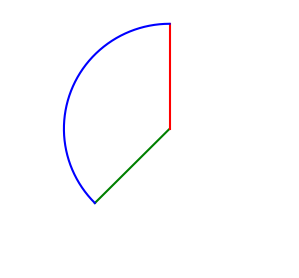

(-2.356194490192345, 1.5707963267948948, -2.3561944901923466)

In [385]:
# ϕ₁ = rand()*2*π
# ϕ₂ = rand()*2*π
Δϕ = mod(ϕ₂,2*π)-mod(ϕ₁,2*π)
if abs(Δϕ) > π
    Δϕ -= sign(Δϕ)*2*π
end
ϕ = collect(linspace(ϕ₁,ϕ₁+Δϕ))

PyPlot.figure(figsize=[3,3])
PyPlot.plot([0, cos(ϕ₁)],[0, sin(ϕ₁)],c="g")
PyPlot.plot([0, cos(ϕ₂)],[0, sin(ϕ₂)],c="r")
PyPlot.plot(cos.(ϕ),sin.(ϕ),c="b")
PyPlot.axis("off")
PyPlot.xlim([-1.1,1.1])
PyPlot.ylim([-1.1,1.1])
ϕ₁,ϕ₂,Δϕ